### Predict Sales Based on Advertising Spend

Scenario:
You work for a small retail company. The manager gives you a dataset with TV, Radio, and Newspaper ad budgets, and wants to know:

"Can you build something simple that predicts how much sales we’ll make if we spend ₹X on TV, Radio, and Newspaper ads?"

🎯 Our Goal:

Build a basic machine learning model that predicts Sales based on TV, Radio, Newspaper ad spends.

In [1]:
# Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Step 2: Load Dataset

In [4]:
df = pd.read_csv("Advertising.csv")

In [5]:
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [6]:
# delete index column - Unnamed: 0

In [7]:
df = df.drop(columns=["Unnamed: 0"])

In [8]:
df.head(1)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1


In [9]:
# Step 3: Explore Dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


Our data has 200 rows and 4 columns, all are float data type

In [11]:
df.describe().round(2)

,TV,Radio,Newspaper,Sales
count,200.00,200.00,200.00,200.00
mean,147.04,23.26,30.55,14.02
std,85.85,14.85,21.78,5.22
min,0.70,0.00,0.30,1.60
25%,74.38,9.98,12.75,10.38
50%,149.75,22.90,25.75,12.90
75%,218.82,36.52,45.10,17.40
max,296.40,49.60,114.00,27.00


1. Check for Missing Data

    Look at the count row:

    Is count same for all columns?

    If not, there are missing values you need to handle.

    if count < total rows, use: df.isnull().sum()

    Observation : all columns have 200 rows, so no missing data


In [12]:
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

2. Understand the Data Range

   For each column:

   What is the min, max, and range (max - min)?

   Are the values in expected limits?

   Large ranges may need scaling (normalization/standardization).

   Observation : 

In [45]:
min = []
max = []
range = []

for col in df.columns:
    _min = df[col].min()
    _max = df[col].max()
    
    min.append(_min)
    max.append(_max)  

    _range = _max - _min
    range.append(_range)
summary = pd.DataFrame({
        "Column":df.columns,
        "Min":min,
        "Max":max,
        "Range":range,
})
summary

,Column,Min,Max,Range
0,TV,0.7,296.4,295.7
1,Radio,0.0,49.6,49.6
2,Newspaper,0.3,114.0,113.7
3,Sales,1.6,27.0,25.4


 3. Measure the Spread (std)

    std tells how spread out the values are.

    High std → wide variation → possibly skewed or unstable data.

    Compare std to mean: std / mean gives coefficient of variation.

In [44]:
_std = []
_mean = []
_variablity = []

for col in df.columns:
    std = np.std(df[col]).round(2)
    mean = np.mean(df[col]).round(2)
    variability = f"{(std / mean * 100):.2f}%"
    
    _std.append(std)
    _mean.append(mean)
    _variablity.append(variability)

summary = pd.DataFrame({
    "Column" : df.columns,
    "Std" : _std,
    "Mean" : _mean,
    "Variablity" : _variablity
})
summary

,Column,Std,Mean,Variablity
0,TV,85.64,147.04,58.24%
1,Radio,14.81,23.26,63.67%
2,Newspaper,21.72,30.55,71.10%
3,Sales,5.20,14.02,37.09%


TV has less, radio have moderate and Newspaper have higher variablity 

Variablity means inconsistant pattern, so more unpredictable

4. Identify Skewness
  
  Compare mean and median (50%):

  mean > median → right-skewed

  mean < median → left-skewed

  mean ≈ median → symmetric

In [57]:
mean = []
median = []
obs = []
dif = []

for col in df.columns:
    _mean = df[col].mean()
    _median = df[col].median()
    _dif = _mean - _median
    
    mean.append(_mean)
    median.append(_median)
    dif.append(_dif)
    threshold = 0.05 * _mean
    
    if (_mean - _median) <= threshold:
        obs.append("Approximately Symmetric")
    elif _mean > _median:
        obs.append("Right Skewed")
    else:
        obs.append("Left Skewed")

summary = pd.DataFrame({
    "Columns":df.columns,
    "Mean": mean,
    "Median" : median,
    "Difference" : dif,
    "Observation": obs
})
summary

,Columns,Mean,Median,Difference,Observation
0,TV,147.0425,149.75,-2.7075,Approximately Symmetric
1,Radio,23.2640,22.90,0.3640,Approximately Symmetric
2,Newspaper,30.5540,25.75,4.8040,Right Skewed
3,Sales,14.0225,12.90,1.1225,Right Skewed


 5. Find Outliers

    Compare:

    min vs 25% and max vs 75%
    
    If values are far outside the interquartile range (IQR), they might be outliers
    
    IQR = 75% - 25%

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR


In [70]:
# Step 1: Calculate Q1 and Q3
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

# Step 2: Calculate IQR
iqr = q3 - q1

# Step 3: Calculate bounds
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = pd.DataFrame()

for col in df.columns:
    outliers_in_col = df[(df[col] < lower[col]) | (df[col] > upper[col])]
    outliers = pd.concat([outliers, outliers_in_col])

# Drop duplicate rows (if a row is outlier in multiple columns)
outliers = outliers.drop_duplicates()

outliers


,TV,Radio,Newspaper,Sales
16,67.8,36.6,114.0,12.5
101,296.4,36.3,100.9,23.8


We found these outlier in our data

| Pattern                               | Meaning                            |
| ------------------------------------- | ---------------------------------- |
| High sales + Low spend                | 🟢 Efficient strategy              |
| High spend + Low sales                | 🔴 Wasteful campaign               |
| Consistent spend + unstable sales     | ⚠️ External market factors         |
| Inconsistent spend + consistent sales | 🟢 Market pull or product strength |


In [75]:
# Step 4: Visualize Relationships

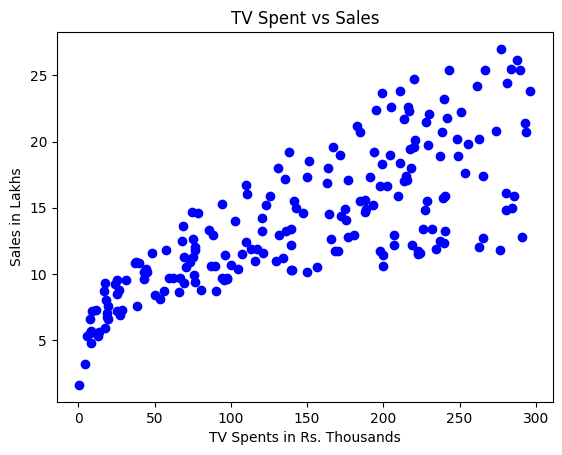

In [82]:
plt.scatter(df["TV"], df["Sales"], color="blue")
plt.title("TV Spent vs Sales")
plt.xlabel("TV Spents in Rs. Thousands")
plt.ylabel("Sales in Lakhs")
plt.show()

TV spend is high and correlates with sales
→ TV is effective; it drives results.

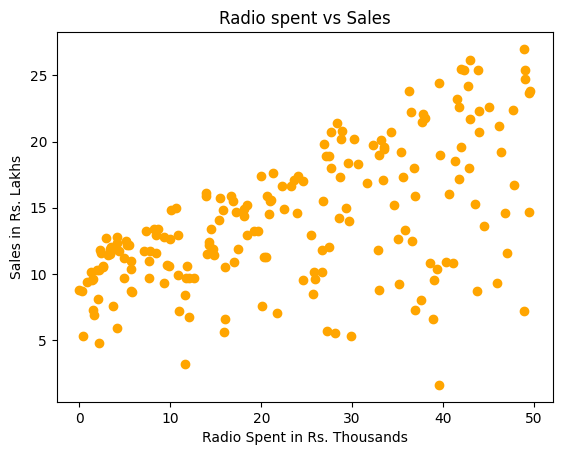

In [83]:
plt.scatter(df["Radio"], df["Sales"], color="orange")
plt.title("Radio spent vs Sales")
plt.xlabel("Radio Spent in Rs. Thousands")
plt.ylabel("Sales in Rs. Lakhs")
plt.show()

Some outliers are here, we spent 40-50 Thousands and sales is very low

<Axes: ylabel='Radio'>

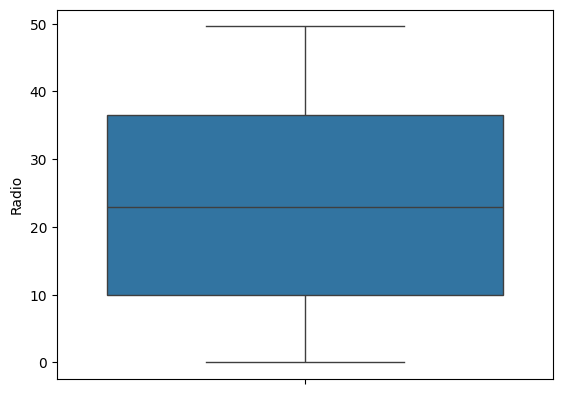

In [95]:
sns.boxplot(df["Radio"])

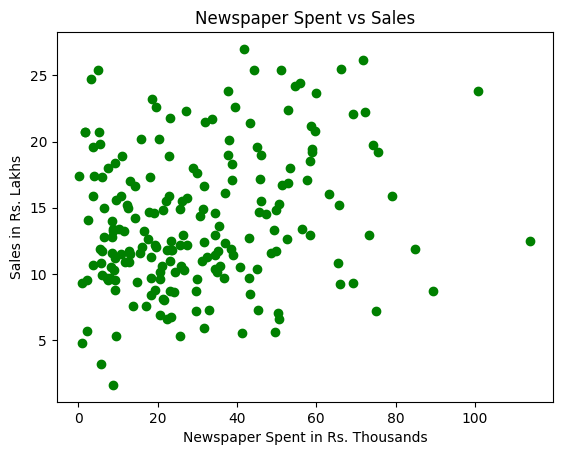

In [85]:
plt.scatter(df["Newspaper"], df["Sales"], color="green")
plt.title("Newspaper Spent vs Sales")
plt.xlabel("Newspaper Spent in Rs. Thousands")
plt.ylabel("Sales in Rs. Lakhs")
plt.show()

Less spent, high sales high spent low , no clear pattern

<Axes: ylabel='Newspaper'>

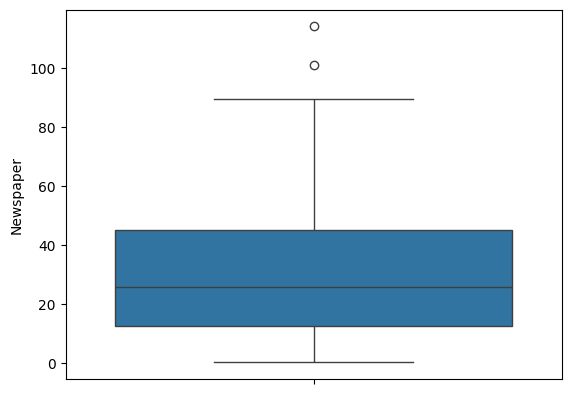

In [96]:
sns.boxplot(df["Newspaper"])

In [98]:
q1 = df["Newspaper"].quantile(0.25)
q3 = df["Newspaper"].quantile(0.75)

iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
mean = df["Newspaper"].mean()
df["Newspaper"] = df["Newspaper"].apply(lambda x: mean if x < lower or x > upper else x) 

<Axes: ylabel='Newspaper'>

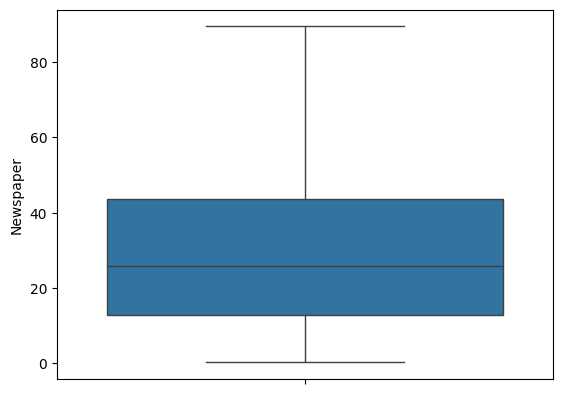

In [99]:
sns.boxplot(df["Newspaper"])

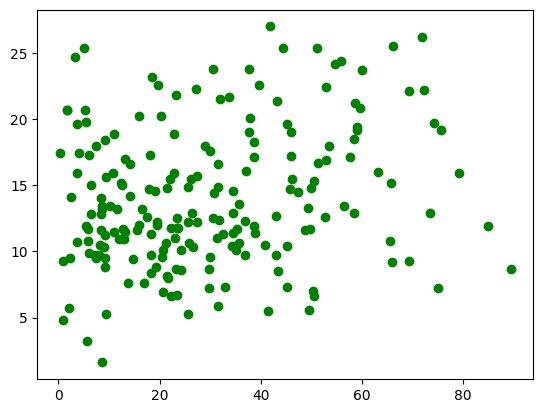

In [101]:
plt.scatter(df["Newspaper"], df["Sales"], color="green")

In [102]:
# Step 5: Train Model

In [104]:
X = df[["TV", "Radio","Newspaper"]] 
y = df["Sales"]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [106]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [107]:
# Step 6: Predict & Evaluate

In [109]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

C:\Users\kiran.salve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [111]:
print("\nRMSE", round(rmse, 2))


RMSE 1.78


In [115]:
print("R2 Score", round(r2,2))

R2 Score 0.9


In [116]:
# Step 7: Predict on New Input

In [117]:
new_spend = [[200, 20, 15]]

In [118]:
predicted_sales = model.predict(new_spend)

C:\Users\kiran.salve\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [119]:
print(f"\nPredicted Sales for TV=200, Radio=20, Newspaper=15: {round(predicted_sales[0], 2)}")


Predicted Sales for TV=200, Radio=20, Newspaper=15: 15.76


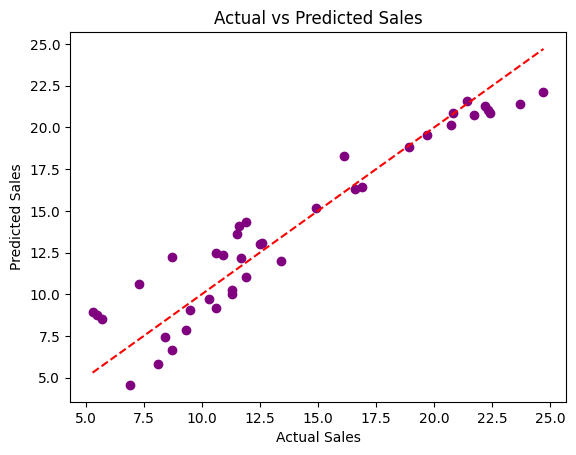

In [121]:
plt.scatter(y_test, y_pred, color='purple')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal reference line
plt.show()

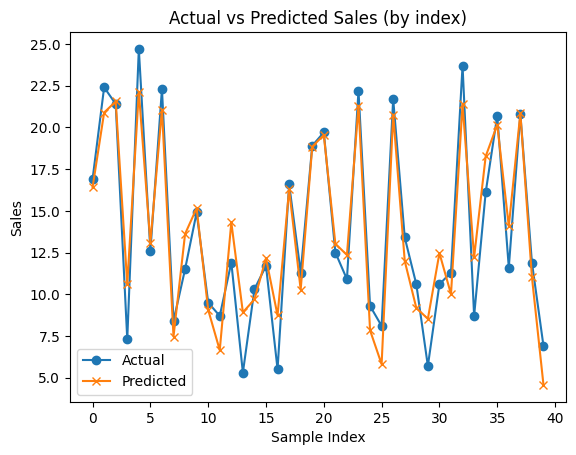

In [123]:
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Actual vs Predicted Sales (by index)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.show()

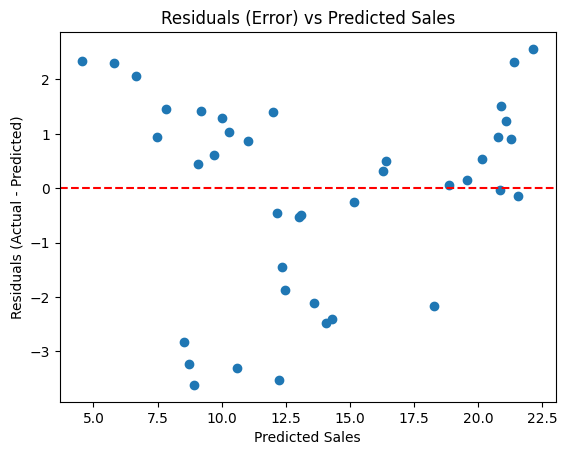

In [124]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Error) vs Predicted Sales")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


In [125]:
# Step 8: Save Actual vs Predicted to CSV

In [127]:
# Step 8: Save Actual vs Predicted to CSV
results_df = pd.DataFrame({
    "TV": X_test['TV'].values,
    "Radio": X_test['Radio'].values,
    "Newspaper": X_test['Newspaper'].values,
    "Actual_Sales": y_test.values,
    "Predicted_Sales": y_pred
})

results_df.to_csv("advertising_predictions.csv", index=False)
print("File saved: advertising_predictions.csv")


File saved: advertising_predictions.csv


In [128]:
!pip install streamlit

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.9 MB 8.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.4/9.9 MB 8.4 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.9 MB 8.4 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/9.9 MB 8.4 MB/s eta 0:00:01
   ---------------------------------- ----- 8.7/9.9 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 8.0 MB/s eta 0:00:00
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Using cached gitdb-4.0.12-py3-non


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
